<a href="https://colab.research.google.com/github/jacheung/auto-curator/blob/master/autocurator_CNN_v1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries and set up image libraries in Google drive
import numpy as np
import scipy.io
import tensorflow as tf 
from tensorflow import keras
from sklearn.utils import class_weight
import sklearn.model_selection as ms
from sklearn.metrics import roc_curve     

from google.colab import drive
import glob
import matplotlib.pyplot as plt
from psutil import virtual_memory
import sys
import time
import dill 
import shelve
from keras.preprocessing.image import ImageDataGenerator


# Mount google drive and set up directories 
drive.mount('/content/gdrive')
base_dir = "/content/gdrive/My Drive/Colab data/trialFramesNPY/"
model_save_dir = "/content/gdrive/My Drive/Colab data/model_iterations/"

# grab images and labels names 
frame_ind_files = glob.glob(base_dir + "*_frameIndex.mat")
T_class = glob.glob(base_dir + "*touchClass.mat")
frames = glob.glob(base_dir + "*dataset.mat")

base_dir = "/content/gdrive/My Drive/Colab data/aug50_real1_100realImsPerFile2/"
aug_files = glob.glob(base_dir + "*.h5")

#                   4/3gEp7zWFwsvd7MRstqM73mJrNwFWCqTFm2a5j3xVvJCGzVG68Ne2Dto

Mounted at /content/gdrive


# 1) Data cleaning


In [ ]:

mem = virtual_memory()
mem_free = np.round(mem.free/1024**3, 2)
tot_mem = np.round(mem.total/1024**3, 2)
print(str(mem_free) + ' of ' + str(tot_mem) + ' GB of mem')

aug_files

## 1.1 Matching frames and labels

In [3]:
# Trim frames and labels names to make the names the same to match them
frame_nums = []
T_class_nums = []
frame_inds = []
for i in range(len(frames)):
  frame_nums.append(frames[i][1:-11])

for i in range(len(T_class)):
  T_class_nums.append(T_class[i][1:-14])
  
for i in range(len(frame_ind_files)):
  frame_inds.append(frame_ind_files[i][1:-14])  
print(frame_inds)

['content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-153_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-154_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-155_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-156_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-157_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-158_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-159_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-160_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-161_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-162_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-163_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-164_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-165_', 'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x00000

In [4]:
# # rearrange frame_nums so that they are in order just for convenience


import re
def extract_between(s, str1, str2):
  result = re.search(str1 + '(.*)' + str2, s)
  return result.group(1)

tmp1 = [int(extract_between(k, '000000-', '_')) for k in frame_nums]
sorted_inds = np.argsort(tmp1)
print(np.max(sorted_inds))
print(np.shape(frame_nums))
frame_nums = [frame_nums[sorted_inds[k]] for k, strings in enumerate(frame_nums)]
frames = [frames[sorted_inds[k]] for k, strings in enumerate(frames)]


tmp1 = [int(extract_between(k, '000000-', '_')) for k in frame_nums]
print(tmp1)
tmp1 = [int(extract_between(k, '000000-', '_')) for k in frames]
print(tmp1)



# print(frame_nums)
# print(frames)

# for k, strings in enumerate(frame_nums):

#   print(k)
#   print(strings)
#   print(sorted_inds[k])
#   frame_nums = strings[sorted_inds[k]]

290
(291,)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [5]:
# Match and reorder all frames and label files
indices = []
T_class_reordered = []
for k in range(len(frame_nums)):
  indices.append([i for i, s in enumerate(T_class_nums) if frame_nums[k] == s])

indices = [x for x in indices if x != []]

for k in range(len(indices)):
    T_class_reordered.append(T_class[indices[k][0]])


#################
indices = []
frame_inds_reordered = []
for k in range(len(frame_nums)):
  indices.append([i for i, s in enumerate(frame_inds) if frame_nums[k] == s])

indices = [x for x in indices if x != []]

for k in range(len(indices)):
    frame_inds_reordered.append(frame_ind_files[indices[k][0]])

#############

# test that this is matched
tmp1 = [int(extract_between(k, '000000-', '_')) for k in T_class_reordered]
print(tmp1)
tmp1 = [int(extract_between(k, '000000-', '_')) for k in frame_nums]
print(tmp1)
tmp1 = [int(extract_between(k, '000000-', '_')) for k in frame_inds_reordered]
print(tmp1)
tmp1 = [int(extract_between(k, '000000-', '_')) for k in frames]
print(tmp1)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [6]:
# load in labels 
# each file represents a trial so for us this could be anywhere between 1 and 4000 data points. 
# most often somewhere between 200-600
raw_Y_set = []
frame_num_in_Y_set = []
for cnt1 in range(len(frames)):
  tmp2 = scipy.io.loadmat(T_class_reordered[cnt1])
  raw_Y_set.append(tmp2['touchClass'])
  frame_num_in_Y_set.append(len(raw_Y_set[cnt1]))

## 1.2 Build Keras Image Generator 
 

In [ ]:
# # test_img = dmatx[50, :, :, :]
# # num_aug_ims = 100
# # tmp1 = fux_wit_imgs(num_aug_ims, test_img)

# def fux_wit_imgs(num_aug_ims, test_img):
#   datagen = ImageDataGenerator(rotation_range=360, #
#                               width_shift_range=.07, #
#                               height_shift_range = .07, #
#                               shear_range = 30,#
#                               zoom_range = .24,
#                               brightness_range=[0.75,1.25])#


#   samples = np.expand_dims(test_img, 0)
#   # prepare iterator
#   it = datagen.flow(samples, batch_size=1)
#   all_augment = samples
#   for i in range(num_aug_ims):##
#     # generate batch of images
#     batch = it.next()
#     # convert to unsigned integers for viewing
#     image = batch[0].astype('uint8')
#     # print(np.shape(all_augment))
#     # print(np.shape(np.expand_dims(image, 0)))
#     all_augment = np.append(all_augment, np.expand_dims(image, 0), 0)
#   np.shape(all_augment)

#   return all_augment

In [7]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, file_trial_list, file_Y_list, num_in_each, batch_size, to_fit) :
    cnt = 0
    extract_inds = []
    # num_in_each contains the number of frames in each file I am loading, ie
    # for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
    for k, elem in enumerate(num_in_each) :
      tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
      # all these files exceded the "batch_size" limit 
      if tot_frame_nums>batch_size or len(num_in_each)-1 == k: # condition met, these files together 
      # meet the max requirment to load together as a batch 
        extract_inds.append([cnt, k+1])
        cnt = k+1 # reset to the current iter
        if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
        # because it excedes the set number of frames
          extract_inds[-1][-1] = extract_inds[-1][-1]-1
          cnt = cnt-1
    
    file_list_chunks = []
    file_Y_list_chunks = []
    for i, ii in enumerate(extract_inds):
      file_list_chunks.append(file_trial_list[ii[0]:ii[1]])
      file_Y_list_chunks.append(file_Y_list[ii[0]:ii[1]])

    self.to_fit = to_fit #set to True to return XY and False to return X
    self.file_trial_list = file_trial_list
    self.file_Y_list = file_Y_list
    self.batch_size = batch_size
    self.extract_inds = extract_inds
    self.num_in_each = num_in_each
    self.file_list_chunks = file_list_chunks
    self.file_Y_list_chunks = file_Y_list_chunks

    
  def __len__(self) :
    return len(self.extract_inds)
  
  def __getitem__(self, num_2_extract) :
    # raw_X, raw_Y = self._build_data(self.file_list_chunks[num_2_extract], 
    #                       self.file_Y_list_chunks[num_2_extract])
    
    raw_X = self._generate_X(self.file_list_chunks[num_2_extract])
    
    rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
    IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

    rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
    rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
    rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

    self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    rgb_tensor_aug = rgb_tensor

    # print(len(raw_Y))
    # for i, ims in enumerate(rgb_tensor):
    #   # print(i)
    #   tmp1 = fux_wit_imgs(20, ims)
    #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
    
    if self.to_fit:
      raw_Y = self._generate_Y(self.file_Y_list_chunks[num_2_extract])
      return rgb_tensor_aug, raw_Y
    else:
      return rgb_tensor_aug


  # def _getitem__tmp(self, touch_aug_num, no_touch_aug_num)

  def get_single_trials(self, num_2_extract) :
      # raw_X, raw_Y = self._build_data([self.file_trial_list[num_2_extract]], 
      #                       [self.file_Y_list[num_2_extract]])
      
      raw_X = self._generate_X(self.file_list_chunks[num_2_extract])
      raw_Y = self._generate_Y(self.file_Y_list_chunks[num_2_extract])

      frame_index = scipy.io.loadmat(self.frame_ind_list[num_2_extract])
      frame_index = frame_index['relevantIdx']
      frame_index = frame_index[0]
      rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
      IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

      rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
      rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
      rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

      self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
      rgb_tensor_aug = rgb_tensor
      # print(len(raw_Y))
      # for i, ims in enumerate(rgb_tensor):
      #   print(i)
      #   tmp1 = fux_wit_imgs(20, ims)
      #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
      return rgb_tensor_aug, raw_Y
    
      # return rgb_tensor, raw_Y, frame_index#, trial_file_num
  # Function to generate an image tensor and corresponding label array

  def _build_data(self, x_files, y_files) :
    """Phils original build data structure used to generate X and Y together. It has been broken down into _generate_X and _generate_Y. Delete ASAP""" 
    cnt1 = -1;

    for k in range(len(y_files)):
      cnt1 = cnt1 + 1
      tmp1 = scipy.io.loadmat(x_files[cnt1])
      tmp2 = scipy.io.loadmat(y_files[cnt1])

      Xtmp = tmp1['finalMat']
      Ytmp = tmp2['touchClass']
      if cnt1==0:
        raw_X = Xtmp
        raw_Y = Ytmp
      else:

        raw_X = np.concatenate((raw_X,Xtmp), axis=0)
        raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)

    return raw_X, raw_Y

  def _generate_X(self, x_files) :
    cnt1 = -1;

    for k in range(len(x_files)):
      cnt1 = cnt1 + 1
      tmp1 = scipy.io.loadmat(x_files[cnt1])
      Xtmp = tmp1['finalMat']
      
      if cnt1==0:
        raw_X = Xtmp      
      else:
        raw_X = np.concatenate((raw_X,Xtmp), axis=0)
        
    return raw_X
    
  def _generate_Y(self, y_files) :
    cnt1 = -1;

    for k in range(len(y_files)):
      cnt1 = cnt1 + 1
      tmp2 = scipy.io.loadmat(y_files[cnt1])

      Ytmp = tmp2['touchClass']
      if cnt1==0:
        raw_Y = Ytmp
      else:
        raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)

    return raw_Y
  def plot_batch_distribution(self):
      # randomly select a batch and generate images and labels
      batch_num = np.random.choice(np.arange(0, len(self.file_list_chunks)))
      samp_x, samp_y = self.__getitem__(batch_num)

      # look at the distribution of classes
      plt.pie([1 - np.mean(samp_y), np.mean(samp_y)],
              labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%', )
      plt.title('class distribution from batch ' + str(batch_num))
      plt.show()

      # generate indices for positive and negative classes
      images_to_sample = 20
      neg_class = [i for i, val in enumerate(samp_y) if val == 0]
      pos_class = [i for i, val in enumerate(samp_y) if val == 1]
      neg_index = np.random.choice(neg_class, images_to_sample)
      pos_index = np.random.choice(pos_class, images_to_sample)

      # plot sample positive and negative class images
      plt.figure(figsize=(10, 10))
      for i in range(images_to_sample):
          plt.subplot(5, 10, i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          _ = plt.imshow(image_transform(samp_x[neg_index[i]]))
          plt.xlabel('0')

          plt.subplot(5, 10, images_to_sample + i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(image_transform(samp_x[pos_index[i]]))
          plt.xlabel('1')
      plt.suptitle('sample images from batch  ' + str(batch_num))
      plt.show()

In [9]:
# Data splits to train/test/validation sets 

# *** need to get actual data split here
batch_size = 2000
validate_fraction = .3

# for now we will split based on num files not number of frames becasue its easier and shouldnt make
#  too much of a difference -- can fix later if we care to 
mixed_inds = np.random.choice(len(frames), len(frames), replace=False)
validate_count = round(validate_fraction*len(frames))
T_inds = mixed_inds[validate_count+1:-1]
# T_inds = [frames[k] for k in T_inds]
v_inds = mixed_inds[0:validate_count]
# v_inds = [frames[k] for k in v_inds]

my_training_batch_generator = My_Custom_Generator([frames[k] for k in T_inds],
                                                  [T_class_reordered[k] for k in T_inds],
                                                  [frame_num_in_Y_set[k] for k in T_inds],
                                                  batch_size,
                                                  to_fit = True)
my_validation_batch_generator = My_Custom_Generator([frames[k] for k in v_inds],
                                                    [T_class_reordered[k] for k in v_inds],
                                                    [frame_num_in_Y_set[k] for k in v_inds],
                                                    batch_size,
                                                    to_fit = True)

my_test_batch_generator = My_Custom_Generator([frames[k] for k in v_inds],
                                                    [],
                                                    [frame_num_in_Y_set[k] for k in v_inds],
                                                    batch_size,
                                                    to_fit = False)
print(len(frames))


291


#2) Exploratory Data Analysis

We're going to take a look at the distribution of classes and some sample images in randomly selected batches to ensure data quality.  

In [10]:
# image transform from [-1 1] back to [0 255] for imshow
def image_transform(x):
  image = tf.cast((x + 1) * 127.5, tf.uint8)
  return image

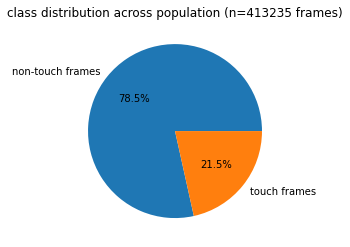

In [9]:
# population distribution of data
total_touch_frames = np.sum([np.sum(k) for k in raw_Y_set]) 
total_non_touch_frames = np.sum([np.sum(k==0) for k in raw_Y_set]) 
total_frames = np.sum(frame_num_in_Y_set)

population = np.array([total_non_touch_frames,total_touch_frames]) / total_frames
plt.pie(population,
        labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%',)
plt.title('class distribution across population (n=' + str(total_frames) + ' frames)')
plt.show()

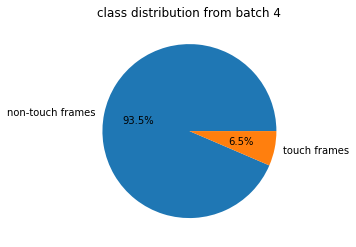

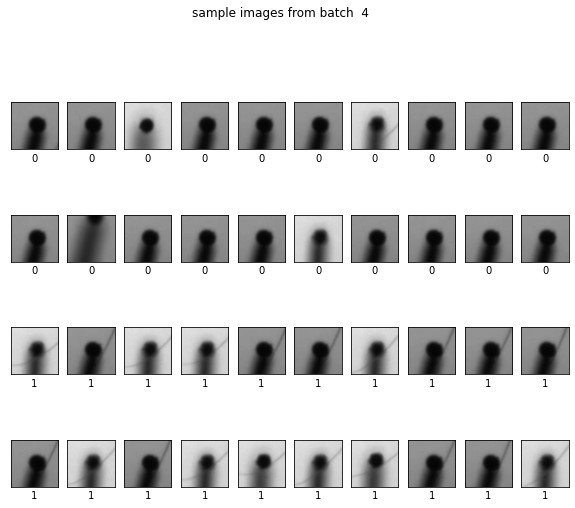

In [11]:
# look at distribution of data and some sample images 
my_training_batch_generator.plot_batch_distribution()

# 3) Feature engineering?


In [12]:
# Y vectorization and class weight calculation 
to_del = 0
start = time.time()

cnt1 = -1;
mem_free = 9999
y_files = my_training_batch_generator.file_Y_list
for k in range(len(y_files)):
  cnt1 = cnt1 + 1
  tmp2 = scipy.io.loadmat(y_files[cnt1])

  Ytmp = tmp2['touchClass']
  if cnt1==0:
    raw_Y_2 = Ytmp
  else:
    raw_Y_2 = np.concatenate((raw_Y_2,Ytmp), axis=0)


# 4) Deploy and selection of base model
In this section we're going to use MobileNetV2 as the base model.
We're going to run two variations of the model.  
a. basemodel with frozen layers and output classifer changes   
b. basemodel with final 100 layers unfrozen to optimize prediction 


In [13]:
# Create base model 

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = 96 # All images will be resized to 96x96. This is the size of MobileNetV2 input sizes
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model.output
print(feature_batch.shape)

# Adding Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Model Stacking
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

print(model.summary())

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


9412608/9406464 [==============================] - 0s 0us/step
(None, 3, 3, 1280)
(None, 1280)
(None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [13]:
start = time.time()

# Fit model with a couple parameters
EPOCHS = 40

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks,
              class_weight = class_weights)


total_seconds = time.time() - start
print('total run time :' + str(round(total_seconds/60)), ' minutes')

todays_version = time.strftime("%Y%m%d", time.gmtime())
end_dir = model_save_dir + '/' + 'cp-final-' + todays_version +'.ckpt'
model.save_weights(end_dir)

Epoch 1/40
159/159 [==============================] - 415s 3s/step - loss: 0.5260 - tp: 49041.0000 - fp: 57532.0000 - tn: 163853.0000 - fn: 11717.0000 - precision: 0.4602 - recall: 0.8072 - auc: 0.8646 - val_loss: 0.4315 - val_tp: 24734.0000 - val_fp: 14496.0000 - val_tn: 83854.0000 - val_fn: 2383.0000 - val_precision: 0.6305 - val_recall: 0.9121 - val_auc: 0.9490
Epoch 2/40
159/159 [==============================] - 112s 706ms/step - loss: 0.3816 - tp: 56778.0000 - fp: 35129.0000 - tn: 186256.0000 - fn: 3980.0000 - precision: 0.6178 - recall: 0.9345 - auc: 0.9542 - val_loss: 0.3387 - val_tp: 26132.0000 - val_fp: 11142.0000 - val_tn: 87208.0000 - val_fn: 985.0000 - val_precision: 0.7011 - val_recall: 0.9637 - val_auc: 0.9705
Epoch 3/40
159/159 [==============================] - 114s 718ms/step - loss: 0.2978 - tp: 58292.0000 - fp: 25010.0000 - tn: 196375.0000 - fn: 2466.0000 - precision: 0.6998 - recall: 0.9594 - auc: 0.9693 - val_loss: 0.3083 - val_tp: 26738.0000 - val_fp: 11593.0000 

In [14]:


latest = tf.train.latest_checkpoint(model_save_dir)
model.load_weights(latest)
# model.save('/content/gdrive/My Drive/Colab data/model_200906_400_000_imgs_2.h5')
# model.load_weights('/content/gdrive/My Drive/Colab data/model_200906_400_000_imgs.h5')


## 4.1) Model learning evaluation 

Here we'll look at metrics of loss, AUC, precision, and recall across epochs of learning 

 

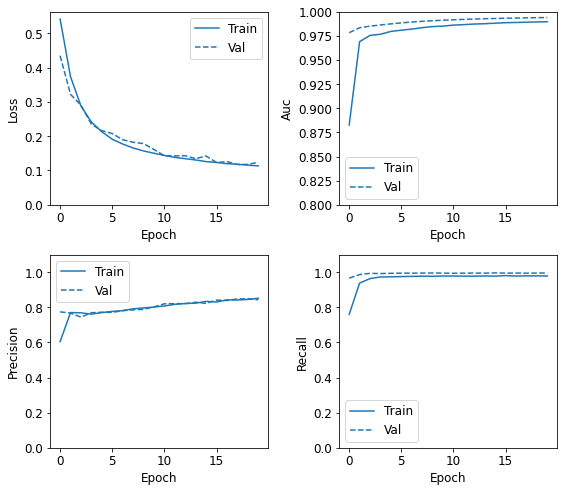

In [71]:
# Overall model evaluation
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  fig = plt.figure(figsize=(8, 7))
  plt.rcParams.update({'font.size':12})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1.1])

    plt.legend()
    plt.tight_layout()

plot_metrics(history)

array([[0.20794153, 0.03614687],
       [0.00452375, 0.75138785]])

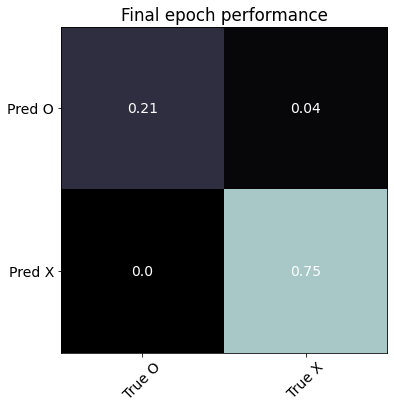

In [72]:
# Confusion matrix last epoch 
def plot_confusion_matrix(history, epoch):
  fig = plt.figure(figsize = (6,6))
  plt.rcParams.update({'font.size':14})
  plt.tight_layout()

  total_samples= history.history['tp'][epoch] + history.history['fp'][epoch] + history.history['tn'][epoch] + history.history['fn'][epoch]
  values = np.array([[history.history['tp'][epoch], history.history['fp'][epoch]],
                      [history.history['fn'][epoch], history.history['tn'][epoch]]]) / total_samples
  for i in range(2):
      for j in range(2):
          text = plt.text(j, i, round(values[i, j],2),
                        ha="center", va="center", color="w")

  im = plt.imshow(values,cmap='bone',vmin=0, vmax=1)
  plt.yticks([0,1],labels=['Pred O', 'Pred X'])
  plt.xticks([0,1],labels = ['True O', 'True X'],rotation=45)
  plt.title('Final epoch performance')
  plt.show
  return values

plot_confusion_matrix(history,-1)

<function matplotlib.pyplot.show>

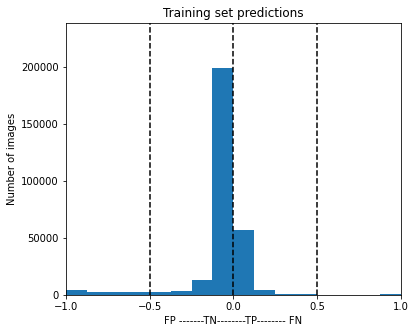

In [15]:
# load all validation data and get distribution of probability differences
accumulator = np.array([])
for batch_num in np.arange(0,len(my_training_batch_generator.file_list_chunks)):
  dmatx, dmaty = my_training_batch_generator.__getitem__(batch_num)
  # mem_breakdown_and_big_vars(locals()) #check to see memory consumption 
  # predict using the trained model and calculate difference from target
  # prob_diff: positive values are false negatives, negative values are false positives 
  predy = model.predict(dmatx)
  prob_diff = dmaty - predy
  accumulator = np.concatenate((accumulator,prob_diff[:,0]))

plt.figure(figsize=(6,5))
plt.xlim([-1, 1])
plt.xticks(np.linspace(-1,1,5))
plt.xlabel('FP -------TN--------TP-------- FN')
plt.ylabel('Number of images')
plt.title('Training set predictions')
l = plt.hist(accumulator,bins=np.linspace(-1,1,17))
for k in np.array([-.5,0,.5]):
  plt.plot([k, k],[0, max(l[0])*1.2],color='k',linestyle='--')
plt.ylim([0, max(l[0])*1.2])
plt.show

In [ ]:
# ROC Analysis

def calculate_roc(batch_generator):
  y_pred = np.array([])
  y_true = np.array([])

  for batch_num in np.arange(0,len(batch_generator.file_list_chunks)):
    dmat_x, dmat_y = batch_generator.__getitem__(batch_num)
    # predict using the trained model and calculate difference from target
    # prob_diff: positive values are false negatives, negative values are false positives 
    pred_y = model.predict(dmat_x)
    y_true = np.concatenate((y_true, dmat_y[:,0]))
    y_pred = np.concatenate((y_pred,pred_y[:,0]))

  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  return fpr, tpr, thresholds

train_fp, train_tp, train_thresh = calculate_roc(my_training_batch_generator)
val_fp, val_tp, val_thresh = calculate_roc(my_validation_batch_generator)

fig,axs = plt.subplots(2,1,figsize=(4,6))
axs[0].plot(train_fp,train_tp,color = 'b',label = 'train')
axs[0].plot(val_fp,val_tp, color = 'b', linestyle="--", label = 'val')
axs[0].set_xlabel('False positive rate (%)')
axs[0].set_ylabel('True positive rate (%)')

axs[1].plot(train_fp,train_tp,color = 'b',label = 'train')
axs[1].plot(val_fp,val_tp, color = 'b', linestyle="--", label = 'val')
axs[1].set_ylim(.9, 1.01)
axs[1].set_xlim(0, .1)
axs[1].set_xticks([0, .3])
axs[1].set_yticks([.7, 1])
axs[1].set_title('zoomed')
axs[1].set_xlabel('False positive rate (%)')
axs[1].set_ylabel('True positive rate (%)')

plt.tight_layout()
plt.legend()
plt.show

## 4.2) Model evaluation of failed images

Here we'll plot 10 images of the False Positive and False Negative cases in each batch. This will help us see what the extreme cases of false negatives and false positives are. 

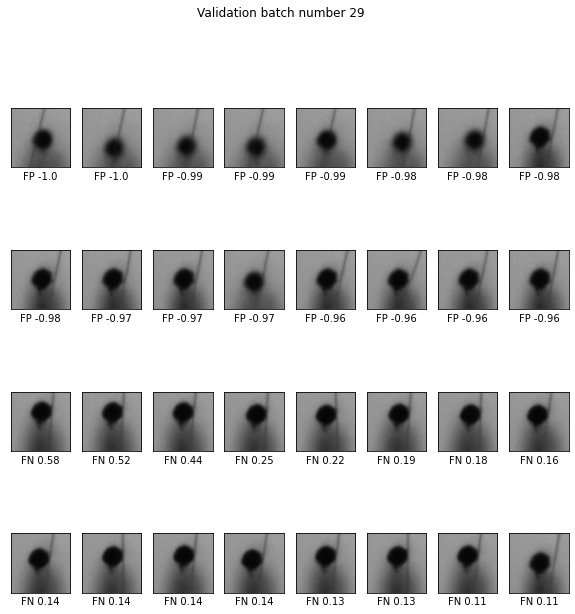

In [ ]:
# load a batch of data
batch_num = np.random.choice(np.arange(0,len(my_validation_batch_generator.file_list_chunks)))
dmatx, dmaty = my_validation_batch_generator.__getitem__(batch_num)

# predict using the trained model and calculate difference from target
# prob_diff: positive values are false negatives, negative values are false positives 
predy = model.predict(dmatx)
prob_diff = dmaty - predy

# sorted indices and values for plotting
idx = np.argsort(prob_diff.flatten())
values = np.sort(prob_diff.flatten()).round(2)

images_to_sample = 16

plt.figure(figsize=(10,10))
for i in range(images_to_sample):
    plt.subplot(4,images_to_sample/2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    _ = plt.imshow(image_transform(dmatx[idx[i]]))
    plt.xlabel('FP ' + str(values[i]))

    plt.subplot(4,images_to_sample/2,images_to_sample+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_transform(dmatx[idx[-i -1]]))
    plt.xlabel('FN ' + str(values[-i -1]))

plt.suptitle('Validation batch number ' + str(batch_num))
plt.show()



# 5) Hyperparameter tuning 
 Here we'll loosen up a couple of the top layers for training to see if we can boost performance 

"In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning"

In [ ]:
# Fine-tuning model by unfreezing layers and allowing them to be trainable

model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

# compile model with a much slower learning rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


Number of layers in the base model:  3


In [ ]:
start = time.time()

# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks,
              class_weight = class_weights)

total_seconds = time.time() - start
print('total time took ' + str(round(total_seconds/60)), ' minutes')

Epoch 1/20
155/155 [==============================] - 86s 554ms/step - loss: 0.1233 - tp: 58560.0000 - fp: 12586.0000 - tn: 209167.0000 - fn: 783.0000 - precision: 0.8231 - recall: 0.9868 - auc: 0.9898 - val_loss: 0.1665 - val_tp: 28208.0000 - val_fp: 6905.0000 - val_tn: 91002.0000 - val_fn: 456.0000 - val_precision: 0.8033 - val_recall: 0.9841 - val_auc: 0.9861
Epoch 2/20
155/155 [==============================] - 84s 544ms/step - loss: 0.1233 - tp: 58560.0000 - fp: 12586.0000 - tn: 209167.0000 - fn: 783.0000 - precision: 0.8231 - recall: 0.9868 - auc: 0.9898 - val_loss: 0.1665 - val_tp: 28208.0000 - val_fp: 6905.0000 - val_tn: 91002.0000 - val_fn: 456.0000 - val_precision: 0.8033 - val_recall: 0.9841 - val_auc: 0.9861
Epoch 3/20
155/155 [==============================] - 85s 548ms/step - loss: 0.1233 - tp: 58560.0000 - fp: 12586.0000 - tn: 209167.0000 - fn: 783.0000 - precision: 0.8231 - recall: 0.9868 - auc: 0.9898 - val_loss: 0.1665 - val_tp: 28208.0000 - val_fp: 6905.0000 - val_tn

# 6) Test set on model 


In [18]:
predictions = model.predict(my_test_batch_generator)

0.25191114771820544

# ---- DONE ---- 

In [ ]:
test_img = dmatx[50:52, :, :, :]
test_img = (test_img+1)/2*255

# example of random rotation image augmentation
from keras.preprocessing.image import ImageDataGenerator
# load the image
data = test_img
# # convert to numpy array
# data = img_to_array(img)
# expand dimension to one sample
print(np.shape(data))

samples = np.expand_dims(data, 0)
print(np.shape(samples))

samples = data
print(np.shape(samples))

# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=360, #
                             width_shift_range=.07, #
                             height_shift_range = .07, #
                             shear_range = 30,#
                             zoom_range = .24,
                             brightness_range=[0.75,1.25])#
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(20,20))

for i in range(50):
	# define subplot
	plt.subplot(5, 10, i+1)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()
np.shape(image)

TypeError: ignored

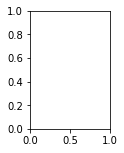

In [ ]:
# print(np.shape())
# print(96/2)
test_img = dmatx[39, :, :, :]


test_img = (test_img+1)/2
# print(np.max(test_img))
# print(np.min(test_img))
images_to_sample = 12
plt.figure(figsize=(10,10))

for i in range(images_to_sample):

  plt.subplot(4,images_to_sample/2,i+1)
  tmp1 = tf.keras.preprocessing.image.random_rotation(
      test_img,1, row_axis=48, col_axis=48, channel_axis=0, fill_mode='nearest', cval=0.0,
      interpolation_order=1
  )
  if i == 0:
    plt.imshow(test_img)
  else:
    plt.imshow(tmp1)

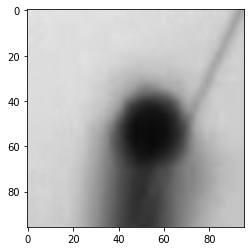

In [ ]:
    plt.imshow(test_img)


In [ ]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.25),
])

# augmented_image = data_augmentation(tf.expand_dims(img, 0), training=True)
# show(img,augmented_image[0].numpy())

NameError: ignored

In [ ]:
class_predict = []
is_val_data = []
for n, trial_name in enumerate(my_validation_batch_generator.file_trial_list):
  # print(n)
  dmatx, dmaty = my_validation_batch_generator.get_single_trials(n)
  tmp1= model.predict(dmatx)
  class_predict.append(tmp1)
  is_val_data.append(1)
for n, trial_name in enumerate(my_training_batch_generator.file_trial_list):
  # print(n)
  dmatx, dmaty = my_training_batch_generator.get_single_trials(n)
  tmp1= model.predict(dmatx)
  class_predict.append(tmp1)
  is_val_data.append(0)


In [ ]:
all_files = my_validation_batch_generator.file_trial_list + my_training_batch_generator.file_trial_list
tmp1 = [all_files, class_predict, is_val_data]
scipy.io.savemat('/content/gdrive/My Drive/Colab data/all_pred_200828_1.mat', mdict={'my_list': tmp1})

In [ ]:



filename='/content/gdrive/My Drive/Colab data/allSaveData200828_2.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
# dont_save_vars = ['exit', 'get_ipython']
dont_save_vars = ['In', 'Out', '_', '_1', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_i3', '_i4', '_ih', '_ii', '_iii', '_oh', '_sh', 'exit', 'get_ipython', 'quit']
for key in dir():
  if all([key != k for k in dont_save_vars]):
    try:
      my_shelf[key] = globals()[key]
    except TypeError:
      #
      # __builtins__, my_shelf, and imported modules can not be shelved.
      #
      print('ERROR shelving: {0}'.format(key))
      # print('ERROR')
my_shelf.close()

ERROR shelving: METRICS
ERROR shelving: base_model
ERROR shelving: callbacks
ERROR shelving: class_weight
ERROR shelving: drive
ERROR shelving: feature_batch
ERROR shelving: feature_batch_average
ERROR shelving: glob
ERROR shelving: global_average_layer
ERROR shelving: history
ERROR shelving: keras
ERROR shelving: model
ERROR shelving: ms
ERROR shelving: my_shelf
ERROR shelving: np
ERROR shelving: plt
ERROR shelving: prediction_batch
ERROR shelving: prediction_layer
ERROR shelving: scipy
ERROR shelving: shelve
ERROR shelving: sys
ERROR shelving: tf
ERROR shelving: time


In [ ]:
                      #pip install dill --user
filename = '/content/gdrive/My Drive/Colab data/globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
dill.load_session(filename)

In [ ]:
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
dill.load_session(filename)

TypeError: ignored

In [ ]:
model.save('/content/gdrive/My Drive/Colab data/model_200828_1.h5')


In [114]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, file_trial_list, file_Y_list, num_in_each, batch_size, to_fit) :
    cnt = 0
    extract_inds = []
    # num_in_each contains the number of frames in each file I am loading, ie
    # for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
    for k, elem in enumerate(num_in_each) :
      tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
      # all these files exceded the "batch_size" limit 
      if tot_frame_nums>batch_size or len(num_in_each)-1 == k: # condition met, these files together 
      # meet the max requirment to load together as a batch 
        extract_inds.append([cnt, k+1])
        cnt = k+1 # reset to the current iter
        if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
        # because it excedes the set number of frames
          extract_inds[-1][-1] = extract_inds[-1][-1]-1
          cnt = cnt-1
    
    file_list_chunks = []
    file_Y_list_chunks = []
    for i, ii in enumerate(extract_inds):
      file_list_chunks.append(file_trial_list[ii[0]:ii[1]])
      file_Y_list_chunks.append(file_Y_list[ii[0]:ii[1]])

    self.to_fit = to_fit #set to True to return XY and False to return X
    self.file_trial_list = file_trial_list
    self.file_Y_list = file_Y_list
    self.batch_size = batch_size
    self.extract_inds = extract_inds
    self.num_in_each = num_in_each
    self.file_list_chunks = file_list_chunks
    self.file_Y_list_chunks = file_Y_list_chunks

    
  def __len__(self) :
    return len(self.extract_inds)
  
  def __getitem__(self, num_2_extract) :
    # raw_X, raw_Y = self._build_data(self.file_list_chunks[num_2_extract], 
    #                       self.file_Y_list_chunks[num_2_extract])
    
    raw_X = self._generate_X(self.file_list_chunks[num_2_extract])
    
    rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
    IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

    rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
    rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
    rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

    self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    rgb_tensor_aug = rgb_tensor

    # print(len(raw_Y))
    # for i, ims in enumerate(rgb_tensor):
    #   # print(i)
    #   tmp1 = fux_wit_imgs(20, ims)
    #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
    
    if self.to_fit:
      raw_Y = self._generate_Y(self.file_Y_list_chunks[num_2_extract])
      return rgb_tensor_aug, raw_Y
    else:
      return rgb_tensor_aug


  # def _getitem__tmp(self, touch_aug_num, no_touch_aug_num)

  def get_single_trials(self, num_2_extract) :
      # raw_X, raw_Y = self._build_data([self.file_trial_list[num_2_extract]], 
      #                       [self.file_Y_list[num_2_extract]])
      
      raw_X = self._generate_X(self.file_list_chunks[num_2_extract])
      raw_Y = self._generate_Y(self.file_Y_list_chunks[num_2_extract])

      frame_index = scipy.io.loadmat(self.frame_ind_list[num_2_extract])
      frame_index = frame_index['relevantIdx']
      frame_index = frame_index[0]
      rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
      IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

      rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
      rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
      rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

      self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
      rgb_tensor_aug = rgb_tensor
      # print(len(raw_Y))
      # for i, ims in enumerate(rgb_tensor):
      #   print(i)
      #   tmp1 = fux_wit_imgs(20, ims)
      #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
      return rgb_tensor_aug, raw_Y
    
      # return rgb_tensor, raw_Y, frame_index#, trial_file_num
  # Function to generate an image tensor and corresponding label array

  def _build_data(self, x_files, y_files) :
    """Phils original build data structure used to generate X and Y together. It has been broken down into _generate_X and _generate_Y. Delete ASAP""" 
    cnt1 = -1;

    for k in range(len(y_files)):
      cnt1 = cnt1 + 1
      tmp1 = scipy.io.loadmat(x_files[cnt1])
      tmp2 = scipy.io.loadmat(y_files[cnt1])

      Xtmp = tmp1['finalMat']
      Ytmp = tmp2['touchClass']
      if cnt1==0:
        raw_X = Xtmp
        raw_Y = Ytmp
      else:

        raw_X = np.concatenate((raw_X,Xtmp), axis=0)
        raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)

    return raw_X, raw_Y

  def _generate_X(self, x_files) :
    cnt1 = -1;

    for k in range(len(x_files)):
      cnt1 = cnt1 + 1
      tmp1 = scipy.io.loadmat(x_files[cnt1])
      Xtmp = tmp1['finalMat']
      
      if cnt1==0:
        raw_X = Xtmp      
      else:
        raw_X = np.concatenate((raw_X,Xtmp), axis=0)
        
    return raw_X
  def _generate_Y(self, y_files) :
    cnt1 = -1;

    for k in range(len(y_files)):
      cnt1 = cnt1 + 1
      tmp2 = scipy.io.loadmat(y_files[cnt1])

      Ytmp = tmp2['touchClass']
      if cnt1==0:
        raw_Y = Ytmp
      else:
        raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)

    return raw_Y
  def plot_batch_distribution(self):
      # randomly select a batch and generate images and labels
      batch_num = np.random.choice(np.arange(0, len(self.file_list_chunks)))
      samp_x, samp_y = self.__getitem__(batch_num)

      # look at the distribution of classes
      plt.pie([1 - np.mean(samp_y), np.mean(samp_y)],
              labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%', )
      plt.title('class distribution from batch ' + str(batch_num))
      plt.show()

      # generate indices for positive and negative classes
      images_to_sample = 20
      neg_class = [i for i, val in enumerate(samp_y) if val == 0]
      pos_class = [i for i, val in enumerate(samp_y) if val == 1]
      neg_index = np.random.choice(neg_class, images_to_sample)
      pos_index = np.random.choice(pos_class, images_to_sample)

      # plot sample positive and negative class images
      plt.figure(figsize=(10, 10))
      for i in range(images_to_sample):
          plt.subplot(5, 10, i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          _ = plt.imshow(image_transform(samp_x[neg_index[i]]))
          plt.xlabel('0')

          plt.subplot(5, 10, images_to_sample + i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(image_transform(samp_x[pos_index[i]]))
          plt.xlabel('1')
      plt.suptitle('sample images from batch  ' + str(batch_num))
      plt.show()

In [128]:
my_training_batch_generator = My_Custom_Generator([frames[k] for k in T_inds],
                                                  [T_class_reordered[k] for k in T_inds],
                                                  [frame_num_in_Y_set[k] for k in T_inds],
                                                  batch_size,
                                                  to_fit = True)
test_batch_generator = My_Custom_Generator([frames[k] for k in T_inds],
                                                  [],
                                                  [frame_num_in_Y_set[k] for k in T_inds],
                                                  batch_size,
                                                  to_fit = False)



<tf.Tensor: shape=(1922, 96, 96, 3), dtype=float32, numpy=
array([[[[0.28627455, 0.28627455, 0.28627455],
         [0.28272063, 0.28272063, 0.28272063],
         [0.28051475, 0.28051475, 0.28051475],
         ...,
         [0.38892975, 0.38892975, 0.38892975],
         [0.38823533, 0.38823533, 0.38823533],
         [0.38823533, 0.38823533, 0.38823533]],

        [[0.28627455, 0.28627455, 0.28627455],
         [0.284331  , 0.284331  , 0.284331  ],
         [0.28343934, 0.28343934, 0.28343934],
         ...,
         [0.38892975, 0.38892975, 0.38892975],
         [0.38823533, 0.38823533, 0.38823533],
         [0.38823533, 0.38823533, 0.38823533]],

        [[0.28627455, 0.28627455, 0.28627455],
         [0.28658924, 0.28658924, 0.28658924],
         [0.28754047, 0.28754047, 0.28754047],
         ...,
         [0.3882353 , 0.3882353 , 0.3882353 ],
         [0.38830045, 0.38830045, 0.38830045],
         [0.38892978, 0.38892978, 0.38892978]],

        ...,

        [[0.19215691, 0.19215691,

# Phil's old generator

In [79]:
# Function to generate an image tensor and corresponding label array

def build_data(x_files, y_files) :
  to_del = 0
  start = time.time()

  cnt1 = -1;
  mem_free = 9999

  for k in range(len(y_files)):
    cnt1 = cnt1 + 1
    tmp1 = scipy.io.loadmat(x_files[cnt1])
    tmp2 = scipy.io.loadmat(y_files[cnt1])

    Xtmp = tmp1['finalMat']
    Ytmp = tmp2['touchClass']
    if cnt1==0:
      raw_X = Xtmp
      raw_Y = Ytmp
    else:

      raw_X = np.concatenate((raw_X,Xtmp), axis=0)
      raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)
    # if ((time.time() - start) > 10000) or cnt1>=len(x_files)-1:# update every 10 seconds or when loop ends
    #   print(len(x_files))
    #   mem = virtual_memory()
    #   mem_free = mem.free/1024**3;
    #   start = time.time()
    #   print('free mem = ' +  str(mem_free))

  return raw_X, raw_Y



make a custom class to help load in the data to prevent crashing due to over using RAM 
This class will 
- chunk the files based on the total frames contained in them based on "batch_size" variable 


In [88]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, file_trial_list, file_Y_list, num_in_each, batch_size, to_fit) :
    cnt = 0
    extract_inds = []
    # num_in_each contains the number of frames in each file I am loading, ie
    # for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
    for k, elem in enumerate(num_in_each) :
      tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
      # all these files exceded the "batch_size" limit 
      if tot_frame_nums>batch_size or len(num_in_each)-1 == k: # condition met, these files together 
      # meet the max requirment to load together as a batch 
        extract_inds.append([cnt, k+1])
        cnt = k+1 # reset to the current iter
        if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
        # because it excedes the set number of frames
          extract_inds[-1][-1] = extract_inds[-1][-1]-1
          cnt = cnt-1
    
    file_list_chunks = []
    file_Y_list_chunks = []
    for i, ii in enumerate(extract_inds):
      file_list_chunks.append(file_trial_list[ii[0]:ii[1]])
      file_Y_list_chunks.append(file_Y_list[ii[0]:ii[1]])

    self.to_fit = to_fit #set to True to return XY and False to return X
    self.file_trial_list = file_trial_list
    self.file_Y_list = file_Y_list
    self.batch_size = batch_size
    self.extract_inds = extract_inds
    self.num_in_each = num_in_each
    self.file_list_chunks = file_list_chunks
    self.file_Y_list_chunks = file_Y_list_chunks

    
  def __len__(self) :
    return len(self.extract_inds)
  
  def __getitem__(self, num_2_extract) :
    raw_X, raw_Y = build_data(self.file_list_chunks[num_2_extract], 
                          self.file_Y_list_chunks[num_2_extract])

    rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
    IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

    rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
    rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
    rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

    self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    rgb_tensor_aug = rgb_tensor

    # print(len(raw_Y))
    # for i, ims in enumerate(rgb_tensor):
    #   # print(i)
    #   tmp1 = fux_wit_imgs(20, ims)
    #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
    
    if self.to_fit:
      return rgb_tensor_aug, raw_Y
    else:
      return rgb_tensor_aug


  # def _getitem__tmp(self, touch_aug_num, no_touch_aug_num)

  def get_single_trials(self, num_2_extract) :
      raw_X, raw_Y = build_data([self.file_trial_list[num_2_extract]], 
                            [self.file_Y_list[num_2_extract]])
    
      frame_index = scipy.io.loadmat(self.frame_ind_list[num_2_extract])
      frame_index = frame_index['relevantIdx']
      frame_index = frame_index[0]
      rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
      IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

      rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
      rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
      rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

      self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
      rgb_tensor_aug = rgb_tensor
      # print(len(raw_Y))
      # for i, ims in enumerate(rgb_tensor):
      #   print(i)
      #   tmp1 = fux_wit_imgs(20, ims)
      #   rgb_tensor_aug = np.append(rgb_tensor_aug, tmp1, 0)
      return rgb_tensor_aug, raw_Y
    
      # return rgb_tensor, raw_Y, frame_index#, trial_file_num

  def plot_batch_distribution(self):
      # randomly select a batch and generate images and labels
      batch_num = np.random.choice(np.arange(0, len(self.file_list_chunks)))
      samp_x, samp_y = self.__getitem__(batch_num)

      # look at the distribution of classes
      plt.pie([1 - np.mean(samp_y), np.mean(samp_y)],
              labels=['non-touch frames', 'touch frames'], autopct='%1.1f%%', )
      plt.title('class distribution from batch ' + str(batch_num))
      plt.show()

      # generate indices for positive and negative classes
      images_to_sample = 20
      neg_class = [i for i, val in enumerate(samp_y) if val == 0]
      pos_class = [i for i, val in enumerate(samp_y) if val == 1]
      neg_index = np.random.choice(neg_class, images_to_sample)
      pos_index = np.random.choice(pos_class, images_to_sample)

      # plot sample positive and negative class images
      plt.figure(figsize=(10, 10))
      for i in range(images_to_sample):
          plt.subplot(5, 10, i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          _ = plt.imshow(image_transform(samp_x[neg_index[i]]))
          plt.xlabel('0')

          plt.subplot(5, 10, images_to_sample + i + 1)
          plt.xticks([])
          plt.yticks([])
          plt.grid(False)
          plt.imshow(image_transform(samp_x[pos_index[i]]))
          plt.xlabel('1')
      plt.suptitle('sample images from batch  ' + str(batch_num))
      plt.show()